![](./assets/header.png)

<span style="float: right; font-size: 20px; font-weight: bolder;">Projeto Final</span> 

**Professores:**
- Dr. Gilberto Queiroz
- Dr. Rafael Santos

**Discente:**
- Adriano Almeida

## Índice

- [1. Introdução](#1.-Introdução)
- [2. Período](#2.-Período)
- [3. Fonte dos dados](#3.-Fonte-dos-dados)
- [4. Referências](#4.-Referências)

## Dados

<hr />

O conjunto de dados utilizados nesse trabalho são de radares e foram obtidos a partir dos experimentos do Projeto CHUVA-Manaus (MACHADO et al., 2014) e GoAmazon (MARTIN et al., 2016). Os dados foram obtidos na região de urbanizada de Manaus-AM e em suas redondezas, abrangendo áreas de florestas, pastagens e rios, como ilustrado na Figura 1.

![](./assets/landcover.png)

<span style="display: block; text-align: center;">
    <strong>Figura 1</strong>: Área aproximadamente de onde foram obtidos os dados. <br /> <strong>Fonte</strong>: Autor.</span>
    
## 2. Período

<hr />

Os dados segundo (PEREIRA, 2019), são de 2014 e referem-se a dois períodos denomiados de **Períodos de Operação Intensiva** (IOP – sigla do inglês,
*Intensive Operation Period*), são eles:
- **IOP1**: Corresponde ao fim da estação chuvosa na região. Para este período que começou em 01 de fevereiro e foi até 31 de março, houve um total de 59 dias de observação
- **IOP2**: Corresponde ao período de transição da estações seca e chuvosa. Teve um total de 61 dias de observações entre 15 de agosto a 15 de outubro.

## 3. Fonte dos dados

<hr />

Os dados foram obtidos de diversas fontes, conforme afirmação de (PEREIRA, 2019), são elas:

- **Estação meteorológicas**: Dados com registros da direção do vento, através de anemômetros em estaçòes meteorológicas localizadas no aeroporto de Ponta Pelada e sítios nas redondezas da cidade de Manaus.


- **Radiossondagem**: Dados coletados a partir radiossondas do projeto GoAmazon lançadas em alguns períodos do dia para coletar perfis termodinamicos das tempestades da região de Manaus.


- **Radar banda-S (SIPAM)**: Dados disponibilizados pelo projeto CHUVA-Manaus, provenientes do radar meteorológico operacional de banda-S, operado pelo SIPAM. Suas varreduras foram transformadas no produto CAPPI (*Constant Altitude Plan Position Indicator*) e usado para calcular o acumulado de precipitação em superfície e fazendo sua classificação quanto ao seu tipo ser convectiva ou estratiforme.


- **Redes STARNET, GLD360 e LINET**: Referem-se a redes operacionais de longa distancia na região Amazônica para coletar dados de descargas elétricas atmosféricas em superfícies. Provenientes dos experimentos do projeto CHUVA-Manaus durante a transição entre as estações seca e chuvosa, esses dados registraram a distribuição espacial e temporal da atividade eletrica em superfície.

In [2]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import rasterio as rio
from scipy.stats import pearsonr

In [3]:
DATA = '../data/lite'
mat_data_dir = os.path.join(DATA, 'mat')

In [4]:
mat_data_files = [os.path.join(mat_data_dir, file).replace('\\', '/') 
                  for file in os.listdir(mat_data_dir)]
matdf = [pd.read_csv(file, sep='\s+') for file in mat_data_files]
matdf = pd.concat(matdf, sort=False)
matdf = matdf.rename(str.lower, axis='columns')
matdf.head()

,year,month,day,hour,minute,n_cluster,lon,lat,ind_x,ind_y,reflect,yyyyy_xx1,yyyyy_xx2,yyyyyyy_xx3,yyy_xx4,yyy_xx5,river,cxe,precipit,vil
0,2014.0,8.0,1.0,0.0,0.0,5.0,-60.7114,-1.8089,84.0,53.0,20.3750,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.8345,0.2359
1,2014.0,8.0,1.0,0.0,0.0,5.0,-60.6914,-1.8089,85.0,53.0,20.4531,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.8446,0.2423
2,2014.0,8.0,1.0,0.0,0.0,5.0,-60.6714,-1.8089,86.0,53.0,20.0781,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.7974,0.2460
3,2014.0,8.0,1.0,0.0,0.0,5.0,-60.7714,-1.8289,81.0,54.0,20.5156,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.8527,0.1908
4,2014.0,8.0,1.0,0.0,0.0,5.0,-60.7514,-1.8289,82.0,54.0,23.2969,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.9183,0.2526


Sumarização de algumas estatísticas referente aos dados:

- reflect: Refletividade mínima, média e máxima para cada mês observado.
- precipipit: Precipitação  mínima, média e máxima para cada mês observado.
- yyyyy_xx1: Número de descargas elétricas detectadas pelo sensor negativo da rede GLD360.
- yyyyy_xx2: Número de descargas elétricas detectadas pelo sensor positivo da rede GLD360.
- yyyyyyy_xx3: Número de descargas elétricas detectadas pelos sensores da rede STARNET.
- yyy_xx4: Número de descargas elétricas detectadas pelo sensor negativo da rede LINET.
- yyy_xx5: Número de descargas elétricas detectadas pelo sensor positivo da rede LINET.

In [5]:
aggregated = matdf.groupby(['month']).agg({
    'reflect': ['min', 'mean', 'max'], 
    'precipit': ['min', 'mean', 'max'], 
    'yyyyy_xx1': ['sum'], 
    'yyyyy_xx2': ['sum'],
    'yyyyyyy_xx3': ['sum'],
    'yyy_xx4': ['sum'],
    'yyy_xx5': ['sum'],
})
aggregated

reflect                     precipit                      yyyyy_xx1  \
           min       mean      max      min       mean       max       sum   
month                                                                        
2.0    20.0000  22.237465  28.6406   0.7878   1.303322    4.4302       0.0   
3.0    19.9688  24.017269  36.1562   0.7841   2.215520   14.3779       0.0   
8.0    19.9688  26.856456  56.5469   0.7841   6.409934  350.6001       0.0   
9.0    19.9688  29.325333  52.6250   0.7841  10.352333  189.6784      69.0   
10.0   19.9688  27.909266  54.4688   0.7841   9.332301  253.1879       0.0   

      yyyyy_xx2 yyyyyyy_xx3 yyy_xx4 yyy_xx5  
            sum         sum     sum     sum  
month                                        
2.0         0.0         0.0     0.0     0.0  
3.0         0.0         0.0     0.0     0.0  
8.0         0.0         0.0     0.0     0.0  
9.0       251.0        92.0   109.0    91.0  
10.0        0.0         0.0     0.0     1.0

No handles with labels found to put in legend.


[]

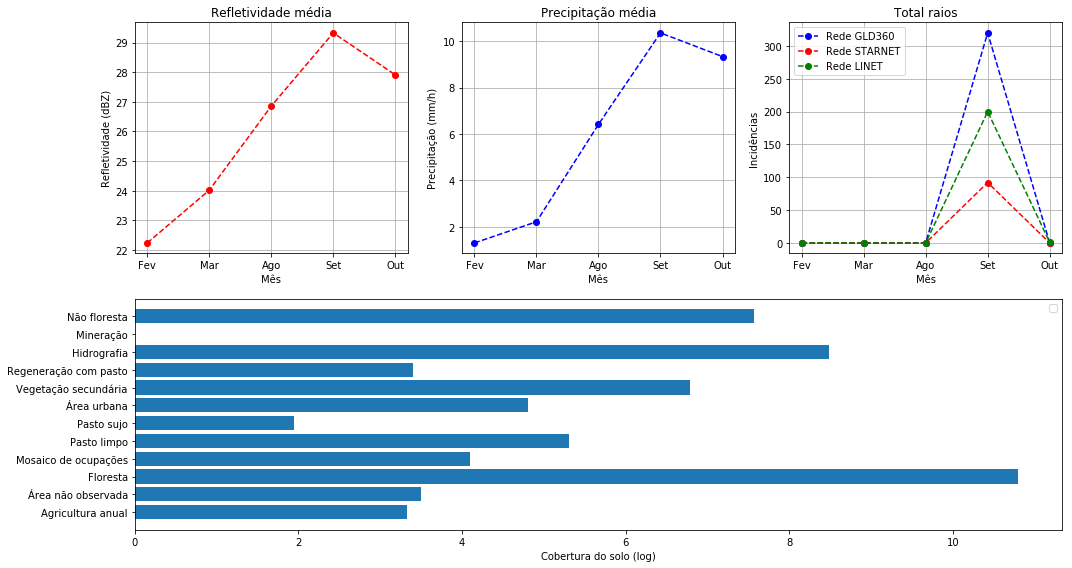

In [6]:
fig = plt.figure(figsize=(15, 8))
months = ['Fev', 'Mar', 'Ago', 'Set', 'Out']
gs = gridspec.GridSpec(2, 3)

ax1 = fig.add_subplot(gs[0, 0])

mean_reflect = aggregated.reflect['mean'].to_list()
ax1.set_title('Refletividade média')
ax1.set_xlabel('Mês')
ax1.set_ylabel('Refletividade (dBZ)')
ax1.plot(months, mean_reflect, 'go--', color='r')
ax1.grid()

ax2 = fig.add_subplot(gs[0, 1])
mean_precipit = aggregated.precipit['mean'].to_list()
ax2.set_title('Precipitação média')
ax2.set_xlabel('Mês')
ax2.set_ylabel('Precipitação (mm/h)')
ax2.plot(months, mean_precipit, 'go--', color='b')
ax2.grid()

##ligning
ax3 = fig.add_subplot(gs[0, 2])
total_light1 = aggregated.yyyyy_xx1['sum']+aggregated.yyyyy_xx2['sum']
total_light1 = total_light1.to_list()
ax3.set_title('Total raios')
ax3.set_xlabel('Mês')
ax3.set_ylabel('Incidências')
ax3.plot(months, total_light1, 'go--', color='b', label='Rede GLD360')
ax3.grid()

total_light1 = aggregated.yyyyyyy_xx3['sum']
total_light1 = total_light1.to_list()
ax3.set_title('Total raios')
ax3.set_xlabel('Mês')
ax3.set_ylabel('Incidências')
ax3.plot(months, total_light1, 'go--', color='r', label='Rede STARNET')
ax3.grid()

total_light1 = aggregated.yyy_xx4['sum']+aggregated.yyy_xx5['sum']
total_light1 = total_light1.to_list()
ax3.set_title('Total raios')
ax3.set_xlabel('Mês')
ax3.set_ylabel('Incidências')
ax3.plot(months, total_light1, 'go--', color='g', label='Rede LINET')
ax3.grid()
ax3.legend()
## end lightning

ax4 = fig.add_subplot(gs[1, :])
with rio.open('./utils/landcover.tif') as src:
    raster = src.read(1, masked=True)
    
landcover = {1: "Agricultura anual", 
            2: "Área não observada", 3: "Floresta", 
            4: "Mosaico de ocupações", 5: "Pasto limpo", 
            6: "Pasto sujo", 7: "Área urbana", 
            8: "Vegetação secundária", 9: "Regeneração com pasto", 
            11: "Hidrografia", 12: "Mineração", 15: "Não floresta"}

classes = {}
for x in range(1, 17):
    if x in landcover.keys():
        classes[x] = 0

for x in range(241):
    for y in range(241):
        pixel = int(raster[x][y])
        if pixel in landcover.keys():
            classes[pixel] += 1
            
classes = [classes[key] for key in classes.keys()]
landcover = [landcover[key] for key in landcover.keys()]
classeslog = np.log(classes)
ax4.barh(landcover, classeslog)
ax4.set_xlabel('Cobertura do solo (log)')
ax4.legend()
# for i, v in enumerate(classes):
#     ax4.text(v+3, i+.25, str(v))
fig.tight_layout()
plt.plot()

In [11]:
aggregated.reflect['mean'].to_list()

[22.23746511627908,
 24.01726860127688,
 26.856456472632484,
 29.32533318872014,
 27.909265631929]

[]

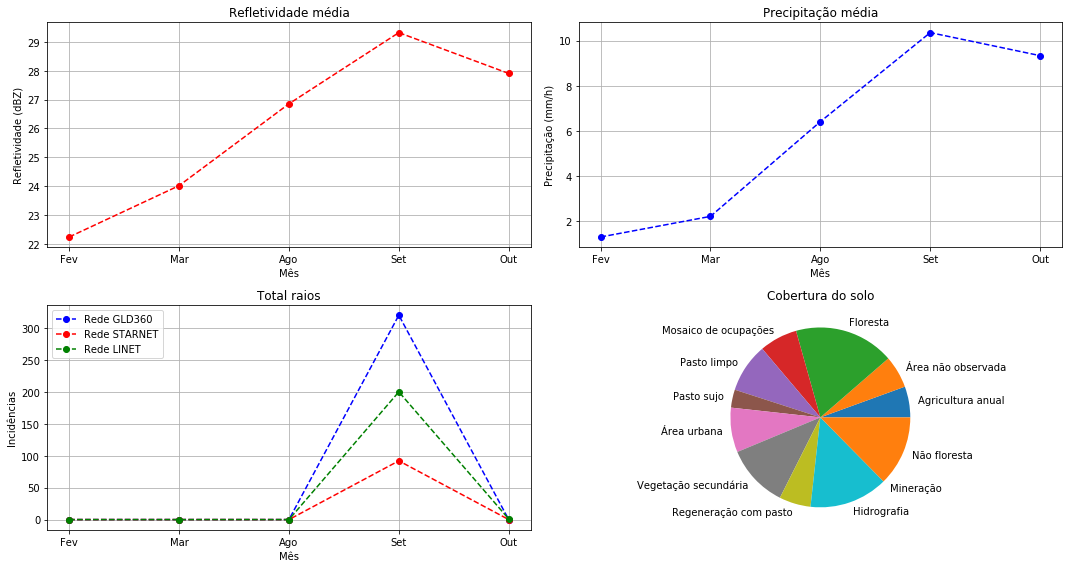

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))

mean_reflect = aggregated.reflect['mean'].to_list()
ax[0, 0].set_title('Refletividade média')
ax[0, 0].set_xlabel('Mês')
ax[0, 0].set_ylabel('Refletividade (dBZ)')
ax[0, 0].plot(months, mean_reflect, 'go--', color='r')
ax[0, 0].grid()

mean_precipit = aggregated.precipit['mean'].to_list()
ax[0, 1].set_title('Precipitação média')
ax[0, 1].set_xlabel('Mês')
ax[0, 1].set_ylabel('Precipitação (mm/h)')
ax[0, 1].plot(months, mean_precipit, 'go--', color='b')
ax[0, 1].grid()

total_light1 = aggregated.yyyyy_xx1['sum']+aggregated.yyyyy_xx2['sum']
total_light1 = total_light1.to_list()
ax[1, 0].set_title('Total raios')
ax[1, 0].set_xlabel('Mês')
ax[1, 0].set_ylabel('Incidências')
ax[1, 0].plot(months, total_light1, 'go--', color='b', label='Rede GLD360')
ax[1, 0].grid()

total_light1 = aggregated.yyyyyyy_xx3['sum']
total_light1 = total_light1.to_list()
ax[1, 0].set_title('Total raios')
ax[1, 0].set_xlabel('Mês')
ax[1, 0].set_ylabel('Incidências')
ax[1, 0].plot(months, total_light1, 'go--', color='r', label='Rede STARNET')
ax[1, 0].grid()

total_light1 = aggregated.yyy_xx4['sum']+aggregated.yyy_xx5['sum']
total_light1 = total_light1.to_list()
ax[1, 0].set_title('Total raios')
ax[1, 0].set_xlabel('Mês')
ax[1, 0].set_ylabel('Incidências')
ax[1, 0].plot(months, total_light1, 'go--', color='g', label='Rede LINET')
ax[1, 0].grid()
# ax[1, 0].label()
ax[1, 0].legend()

with rio.open('./utils/landcover.tif') as src:
    raster = src.read(1, masked=True)
    
landcover = {1: "Agricultura anual", 
            2: "Área não observada", 3: "Floresta", 
            4: "Mosaico de ocupações", 5: "Pasto limpo", 
            6: "Pasto sujo", 7: "Área urbana", 
            8: "Vegetação secundária", 9: "Regeneração com pasto", 
            11: "Hidrografia", 12: "Mineração", 15: "Não floresta"}

classes = {}
for x in range(1, 17):
    if x in landcover.keys():
        classes[x] = 0

for x in range(241):
    for y in range(241):
        pixel = int(raster[x][y])
        if pixel in landcover.keys():
            classes[pixel] += 1
            
classes = [np.log(classes[key]) for key in classes.keys()]
landcover = [landcover[key] for key in landcover.keys()]

ax[1, 1].pie(x=classes, labels=landcover)
ax[1, 1].set_title('Cobertura do solo')
fig.tight_layout()
plt.plot()

In [8]:
pearsonr(mean_precipit, mean_reflect)[0]

0.9823190563396951

## 4. Referências

<hr />

- MACHADO, L. A. T.; SILVA DIAS, M. A. F.; MORALES, C.; FISCH, G.; VILA, D.; ALBRECHT, R. I.; GOODMAN, S. J.; CALHEIROS, A. J. P.; BISCARO, T.; KUMMEROW, C.; COHEN, J.; FITZJARRALD, D.; NASCIMENTO, E. L.; SAKAMOTO, M. S.; CUNNINGHAM, C.; CHABOUREAU, J.-P.; PETERSEN, W. a.; ADAMS, D. K.; BALDINI, L.; ANGELIS, C. F.; SAPUCCI, L. F.; SALIO, P.; BARBOSA, H. M. J.; LANDULFO, E.; SOUZA, R. a. F.; BLAKESLEE, R. J.; BAILEY, J.; FREITAS, S.; LIMA, W. F. a.; TOKAY, A. The Chuva Project: How Does Convection Vary across Brazil? Bulletin of the American Meteorological Society, v. 95, n. 9, p. 1365–1380, set. 2014.


- MARTIN, S. T.; ARTAXO, P.; MACHADO, L. A. T.; MANZI, A. O.; SOUZA, R. A. F.; SCHUMACHER, C.; WANG, J.; ANDREAE, M. O.; BARBOSA, H. M. J.; FAN, J.; FISCH, G.; GOLDSTEIN, A. H.; GUENTHER, A.; JIMENEZ, J. L.; PÖSCHL, U.; SILVA DIAS, M. A.; 98 SMITH, J. N.; WENDISCH, M. Introduction: Observations and Modeling of the Green Ocean Amazon (GoAmazon2014/5). Atmospheric Chemistry and Physics, v. 16, n. 8, p. 4785–4797, abr. 2016.


- PEREIRA, R. F. O. Propriedades Físicas da Precipitação e Eletrificação dos Sistemas Precipitantes Observados Durante o Projeto CHUVA-Manaus e GoAmazon. Dissertação de Mestrado. Departamento de Ciências Atmosféricas do Instituto de Astronomia, Geofísica e Ciências Atmosféricas da Universidade de São Paulo. 2019.

Nesses dados podem ser observado que o mês com a maior ocorrência de descargas elétricas foi setembro.